In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
tf.enable_eager_execution()
import tensorflow.keras.backend as K

## 【問題1】公式チュートリアルモデルを分担して実行

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import unicodedata
import re
import os
import io
import time

In [3]:
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', 
    origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip) + '/spa-eng/spa.txt'

In [4]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) !='Mn')

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = w.rstrip().strip()
    
    w = '<start> ' + w + ' <end>'
    return w

In [5]:
en_sentence = u'May I borrow this book?'
sp_sentence = u'¿Puedo tomar prestado este libro?'
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [6]:
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')] for l in lines[:num_examples]]
    return zip(*word_pairs)

In [7]:
en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [8]:
def max_length(tensor):
    return max([len(t) for t in tensor])

In [9]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)
    
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    return tensor, lang_tokenizer

In [10]:
def load_dataset(path, num_examples=None):
    targ_lang, inp_lang = create_dataset(path, num_examples)
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)
    
    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [11]:
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [12]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

24000 24000 6000 6000


In [13]:
def convert(lang, tensor):
    for t in tensor:
        if t != 0:
            print('%d -----> %s' % (t, lang.index_word[t]))

In [14]:
print('Input language: index to word mapping')
convert(inp_lang, input_tensor_train[0])
print()
print('Target Language: index to word mapping')
convert(targ_lang, target_tensor_train[0])

Input language: index to word mapping
1 -----> <start>
55 -----> fue
1098 -----> repugnante
3 -----> .
2 -----> <end>

Target Language: index to word mapping
1 -----> <start>
10 -----> it
26 -----> was
1347 -----> gross
3 -----> .
2 -----> <end>


In [15]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [16]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([Dimension(64), Dimension(16)]),
 TensorShape([Dimension(64), Dimension(11)]))

In [90]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [91]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# サンプル入力
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 16, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [93]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # スコアを計算するためにこのように加算を実行する
        hidden_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # スコアを self.V に適用するために最後の軸は 1 となる
        # self.V に適用する前のテンソルの shape は  (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))

        # attention_weights の shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector の合計後の shape == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
  
        return context_vector, attention_weights

In [94]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)


In [95]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)
 
        # アテンションのため
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # enc_output の shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # 埋め込み層を通過したあとの x の shape  == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # 結合後の x の shape == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # 結合したベクトルを GRU 層に渡す
        output, state = self.gru(x)

        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [96]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 4935)


In [97]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [98]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [99]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher Forcing - 正解値を次の入力として供給
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)

            # Teacher Forcing を使用
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [100]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
    # 2 エポックごとにモデル（のチェックポイント）を保存
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.5660
Epoch 1 Batch 100 Loss 2.1327
Epoch 1 Batch 200 Loss 1.8769
Epoch 1 Batch 300 Loss 1.7543
Epoch 1 Loss 2.0285
Time taken for 1 epoch 2659.7747387886047 sec

Epoch 2 Batch 0 Loss 1.6109
Epoch 2 Batch 100 Loss 1.4157
Epoch 2 Batch 200 Loss 1.4097
Epoch 2 Batch 300 Loss 1.3260
Epoch 2 Loss 1.4127
Time taken for 1 epoch 2514.6982259750366 sec

Epoch 3 Batch 0 Loss 1.2424
Epoch 3 Batch 100 Loss 1.0586
Epoch 3 Batch 200 Loss 1.0553
Epoch 3 Batch 300 Loss 0.9308
Epoch 3 Loss 1.0304
Time taken for 1 epoch 2318.3936200141907 sec

Epoch 4 Batch 0 Loss 0.8283
Epoch 4 Batch 100 Loss 0.7332
Epoch 4 Batch 200 Loss 0.7981
Epoch 4 Batch 300 Loss 0.6085
Epoch 4 Loss 0.7076
Time taken for 1 epoch 3109.1433548927307 sec

Epoch 5 Batch 0 Loss 0.5665
Epoch 5 Batch 100 Loss 0.5007
Epoch 5 Batch 200 Loss 0.5694
Epoch 5 Batch 300 Loss 0.4116
Epoch 5 Loss 0.4818
Time taken for 1 epoch 7694.158794879913 sec

Epoch 6 Batch 0 Loss 0.3918
Epoch 6 Batch 100 Loss 0.3269
Epoch 6 Batch 200 

In [102]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # 後ほどプロットするためにアテンションの重みを保存
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # 予測された ID がモデルに戻される
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [103]:
# アテンションの重みをプロットする関数
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [104]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [105]:
# checkpoint_dir の中の最後のチェックポイントを復元
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s very cold . <end> 


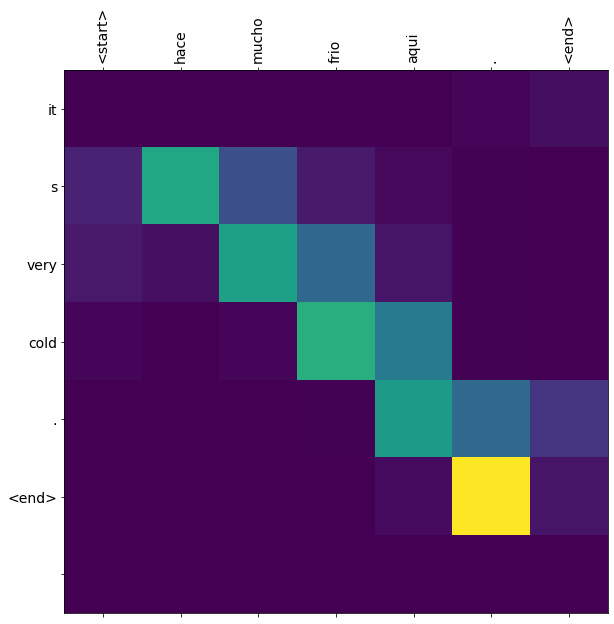

In [106]:
translate(u'hace mucho frio aqui.')

Input: <start> esta es mi vida . <end>
Predicted translation: this is my life . <end> 


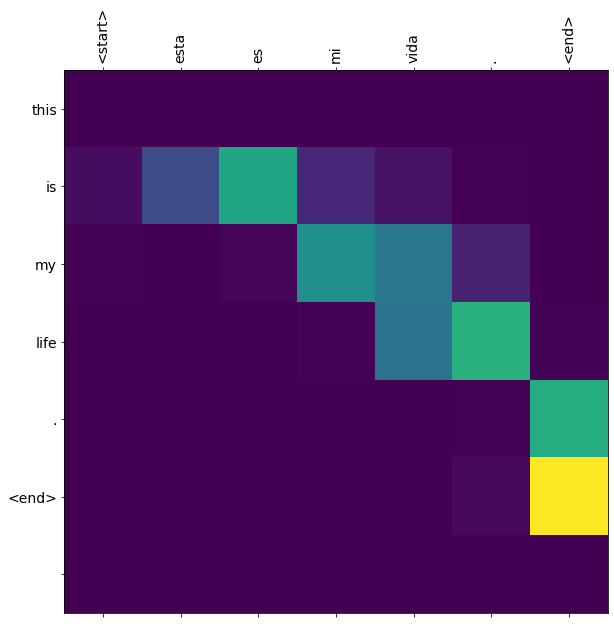

In [107]:
translate(u'esta es mi vida.')

Input: <start> ¿ todavia estan en casa ? <end>
Predicted translation: are you home home ? <end> 


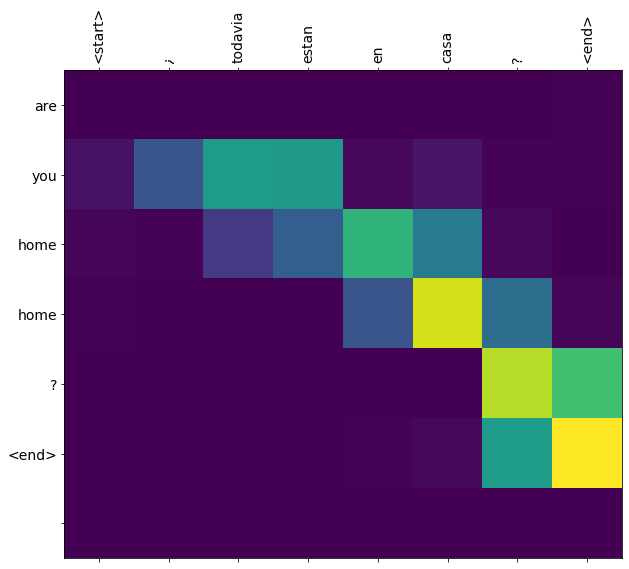

In [108]:
translate(u'¿todavia estan en casa?')

Input: <start> trata de averiguarlo . <end>
Predicted translation: try to figure it out . <end> 


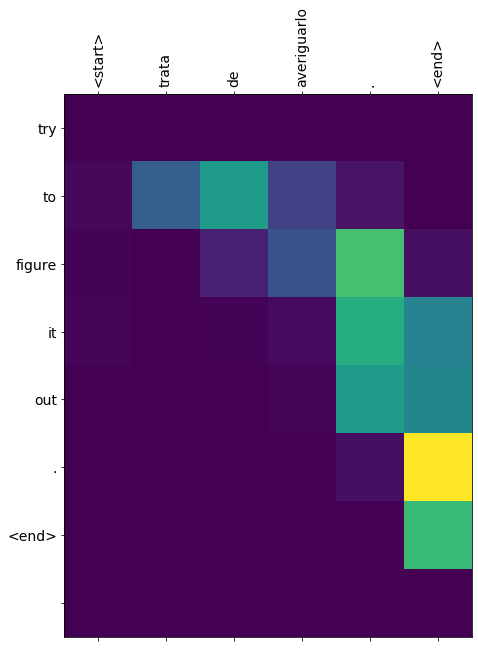

In [109]:
# 翻訳あやまりの例
translate(u'trata de averiguarlo.')

## 【問題3】Iris (2値分類) をKerasで学習

In [18]:
data = load_iris()
X = pd.DataFrame(data.data[:100], columns=data.feature_names, dtype=np.float32).values
y = pd.Series(data.target[:100], dtype=np.float32).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [19]:
input_data = tf.keras.layers.Input(shape=(4,))
x = tf.keras.layers.Dense(50, activation=tf.nn.relu)(input_data)
x = tf.keras.layers.Dense(100, activation=tf.nn.relu)(x)
output = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(x)

model = tf.keras.Model(inputs=input_data, outputs=output)

In [20]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.train.AdamOptimizer(learning_rate=0.01),
              metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=10, epochs=30, verbose=1, validation_data=(X_test, y_test))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 80 samples, validate on 20 samples
Epoch 1/30
80/80 [==============================] - 1s 11ms/sample - loss: 0.1483 - acc: 0.9625 - val_loss: 0.0113 - val_acc: 1.0000
Epoch 2/30
80/80 [==============================] - 0s 407us/sample - loss: 0.0041 - acc: 1.0000 - val_loss: 1.4809e-04 - val_acc: 1.0000
Epoch 3/30
80/80 [==============================] - 0s 356us/sample - loss: 9.2099e-04 - acc: 1.0000 - val_loss: 4.1531e-05 - val_acc: 1.0000
Epoch 4/30
80/80 [==============================] - 0s 420us/sample - loss: 1.0774e-04 - acc: 1.0000 - val_loss: 2.8491e-06 - val_acc: 1.0000
Epoch 5/30
80/80 [==============================] - 0s 560us/sample - loss: 1.6446e-05 - acc: 1.0000 - val_loss: 3.0965e-06 - val_acc: 1.0000
Epoch 6/30
80/80 [==============================] - 0s 489us/sample - loss: 1.3847e-05 - acc: 1.0000 - val_loss: 3.1829e-06 - val_acc: 1.0000
Epoch 7/30
80/80 [=====

## 【問題4】Iris (3値分類) をKerasで学習

In [21]:
data = load_iris()
X = pd.DataFrame(data.data, columns=data.feature_names, dtype=np.float32).values
y = pd.get_dummies(data.target, dtype=np.float32).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [22]:
input_data = tf.keras.layers.Input(shape=(4,))
x = tf.keras.layers.Dense(50, activation=tf.nn.relu)(input_data)
x = tf.keras.layers.Dense(100, activation=tf.nn.relu)(x)
output = tf.keras.layers.Dense(3, activation=tf.nn.softmax)(x)

model = tf.keras.Model(inputs=input_data, outputs=output)

In [23]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.train.AdamOptimizer(learning_rate=0.01),
              metrics=['accuracy'])
history = model.fit(X_train, y_train,
                    batch_size=30,
                    epochs=30,
                    verbose=1,
                    validation_data=(X_test, y_test))

Train on 120 samples, validate on 30 samples
Epoch 1/30
120/120 [==============================] - 1s 5ms/sample - loss: 1.0735 - acc: 0.4083 - val_loss: 0.9478 - val_acc: 0.5667
Epoch 2/30
120/120 [==============================] - 0s 163us/sample - loss: 0.7656 - acc: 0.7000 - val_loss: 0.5657 - val_acc: 0.6667
Epoch 3/30
120/120 [==============================] - 0s 181us/sample - loss: 0.5519 - acc: 0.6667 - val_loss: 0.5205 - val_acc: 0.6667
Epoch 4/30
120/120 [==============================] - 0s 180us/sample - loss: 0.4120 - acc: 0.8583 - val_loss: 0.4263 - val_acc: 0.8667
Epoch 5/30
120/120 [==============================] - 0s 182us/sample - loss: 0.3279 - acc: 0.9417 - val_loss: 0.3301 - val_acc: 0.9333
Epoch 6/30
120/120 [==============================] - 0s 173us/sample - loss: 0.2627 - acc: 0.9500 - val_loss: 0.2600 - val_acc: 0.9333
Epoch 7/30
120/120 [==============================] - 0s 181us/sample - loss: 0.2161 - acc: 0.9500 - val_loss: 0.2224 - val_acc: 0.9000
Epoch

## 【問題5】House PriceをKerasで学習

In [24]:
df = pd.read_csv('../week3/train.csv')
scaler = StandardScaler()
X = scaler.fit_transform(df[['GrLivArea', 'YearBuilt']].values).astype(np.float32)
y = scaler.fit_transform(df[['SalePrice']].values).astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [25]:
input_data = tf.keras.layers.Input(shape=(2,))
x = tf.keras.layers.Dense(100, activation=tf.nn.relu)(input_data)
x = tf.keras.layers.Dense(50, activation=tf.nn.relu)(x)
output = tf.keras.layers.Dense(1, activation=None)(x)

model = tf.keras.Model(inputs=input_data, outputs=output)

In [26]:
model.compile(loss='mean_squared_error',
              optimizer=tf.train.AdamOptimizer(learning_rate=0.0001))

history = model.fit(X_train, y_train, batch_size=100, epochs=10, verbose=1,
                    validation_data=(X_test, y_test))

Train on 1168 samples, validate on 292 samples
Epoch 1/10
1168/1168 [==============================] - 1s 736us/sample - loss: 0.8891 - val_loss: 0.6783
Epoch 2/10
1168/1168 [==============================] - 0s 34us/sample - loss: 0.8206 - val_loss: 0.6257
Epoch 3/10
1168/1168 [==============================] - 0s 36us/sample - loss: 0.7573 - val_loss: 0.5793
Epoch 4/10
1168/1168 [==============================] - 0s 37us/sample - loss: 0.7011 - val_loss: 0.5396
Epoch 5/10
1168/1168 [==============================] - 0s 41us/sample - loss: 0.6512 - val_loss: 0.5046
Epoch 6/10
1168/1168 [==============================] - 0s 40us/sample - loss: 0.6012 - val_loss: 0.4747
Epoch 7/10
1168/1168 [==============================] - 0s 35us/sample - loss: 0.5618 - val_loss: 0.4499
Epoch 8/10
1168/1168 [==============================] - 0s 31us/sample - loss: 0.5239 - val_loss: 0.4294
Epoch 9/10
1168/1168 [==============================] - 0s 31us/sample - loss: 0.4902 - val_loss: 0.4125
Epoch 1

## 【問題6】MNISTをKerasで学習

In [27]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(-1, 28, 28, 1)[:5000]
y_train = y_train[:5000]
X_train = X_train.astype(np.float32)
X_train /= 255

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train_one_hot, test_size=0.2)

Using TensorFlow backend.


In [28]:
K.clear_session( )

input_data = tf.keras.layers.Input(shape=(28, 28, 1))
x = tf.keras.layers.Conv2D(filters=6, kernel_size=5, strides=1, padding='valid',
                           data_format='channels_last',
                           activation=tf.nn.relu)(input_data)
x = tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid', data_format='channels_last')(x)
x = tf.keras.layers.Conv2D(filters=16, kernel_size=5, strides=1, padding='valid',
                           data_format='channels_last',
                           activation=tf.nn.relu)(x)
x = tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid', data_format='channels_last')(x)
x = tf.keras.layers.Flatten(data_format='channels_last')(x)
x = tf.keras.layers.Dense(120, activation=tf.nn.relu)(x)
x = tf.keras.layers.Dense(84, activation=tf.nn.relu)(x)
output = tf.keras.layers.Dense(10, activation=tf.nn.softmax)(x)

model = tf.keras.Model(inputs=input_data, outputs=output)

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 24, 24, 6)         156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 16)          2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               30840 

In [30]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.train.AdamOptimizer(learning_rate=0.0001),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=100, epochs=15, verbose=1,
                    validation_data=(X_test, y_test))

Train on 4000 samples, validate on 1000 samples
Epoch 1/15
4000/4000 [==============================] - 5s 1ms/sample - loss: 2.2656 - acc: 0.2485 - val_loss: 2.2231 - val_acc: 0.4390
Epoch 2/15
4000/4000 [==============================] - 3s 795us/sample - loss: 2.1494 - acc: 0.5220 - val_loss: 2.0617 - val_acc: 0.5700
Epoch 3/15
4000/4000 [==============================] - 3s 739us/sample - loss: 1.8909 - acc: 0.6185 - val_loss: 1.7120 - val_acc: 0.6300
Epoch 4/15
4000/4000 [==============================] - 3s 857us/sample - loss: 1.4570 - acc: 0.6845 - val_loss: 1.2345 - val_acc: 0.7270
Epoch 5/15
4000/4000 [==============================] - 4s 876us/sample - loss: 1.0212 - acc: 0.7722 - val_loss: 0.8812 - val_acc: 0.8050
Epoch 6/15
4000/4000 [==============================] - 3s 810us/sample - loss: 0.7446 - acc: 0.8230 - val_loss: 0.6698 - val_acc: 0.8300
Epoch 7/15
4000/4000 [==============================] - 3s 851us/sample - loss: 0.5930 - acc: 0.8490 - val_loss: 0.5605 - val_